In [1]:
# libraries
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics

/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyper-parameters

In [2]:
hyper_params = {
    'valid_size': 0.2,
    'batch_size': 64,
    'num_workers': 0,
    'num_epochs': 10,
    'lr': 0.001,
    'step_size': 10,
    'gamma': 0.2,
    'num_iterations': 10,
}

downward_params = {
    'in_channels': 3,
    'emb_sizes': [8, 16, 32, 64, 128],
    'kernel_sizes': [3, 3, 3 ,3 ,3],
    'paddings': [1, 1, 1, 1, 1],
    'batch_norm_first': True,
}

upward_params = {
    'in_channels': [128, 256, 128, 64, 32],
    'emb_sizes': [256, 128, 64, 32, 16],
    'out_channels': [128, 64, 32, 16, 8],
    'kernel_sizes': [3, 3, 3, 3, 3],
    'paddings': [1, 1, 1, 1, 1],
    'batch_norm_first': True,
    'bilinear': False,
}

output_params = {
    'in_channels': 16,
    'n_classes': 3,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
STEPS = 20

work_dir = '/global/u2/g/geshi/OxfordIIITPet_Segmentation'
data_dir = '/global/u2/g/geshi/OxfordIIITPet_Segmentation/data'
pretrained_model_path = '/global/u2/g/geshi/OxfordIIITPet_Segmentation/exp/05-02-2023-03:37:44.pt'

# Create model and instance 

In [3]:
import sys
import os
sys.path.append(os.path.join(work_dir, 'src'))

from models import Unet
from input_pipeline import get_datasets

In [4]:
dataloaders, dataset_sizes, classes = get_datasets('OxfordIIITPet', os.path.join(os.getcwd(), data_dir), hyper_params)

In [5]:
criterion = torch.nn.CrossEntropyLoss()

model = Unet(downward_params, upward_params, output_params)
model = model.to(device)
model.eval()
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)
# load the final pretrained model
checkpoint = torch.load(pretrained_model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model_final = copy.deepcopy(model)

# Linear Interpolations of Loss between Two Points

In [6]:
def eval_warm_up(losslandscaper, data_loader, device, criterion):
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            losslandscaper.warm_up(metric)

In [7]:
def eval_loss(losslandscaper, data_loader, device, criterion):
    count = 0
    loss_data = 0.
    with torch.no_grad():
        for count, batch in enumerate(data_loader, 0):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]
            
            metric = loss_landscapes.metrics.Loss(criterion, x, y)
            batch_loss_data = losslandscaper.compute(metric)
            
            loss_data = count/(count+batch_size)*loss_data + batch_size/(count+batch_size)*batch_loss_data
            count+=batch_size
    return loss_data

In [ ]:
# data that the evaluator will use when evaluating loss
# download MNIST and setup data loaders

x, y = iter(dataloaders['train']).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

In [8]:
lll = loss_landscapes.LinearLossLandscape(model_final, STEPS, deepcopy_model=True)
# lll.random_line(distance=10, normalization='filter', random='uniform')
lll.interpolation(model_initial)
lll.stats_initializer()

In [ ]:
# single batch computation
lll.warm_up(metric)
loss_data = lll.compute(metric)

In [9]:
eval_warm_up(lll, dataloaders['train'], device, criterion)

In [10]:
loss_data = eval_loss(lll, dataloaders['train'], device, criterion)

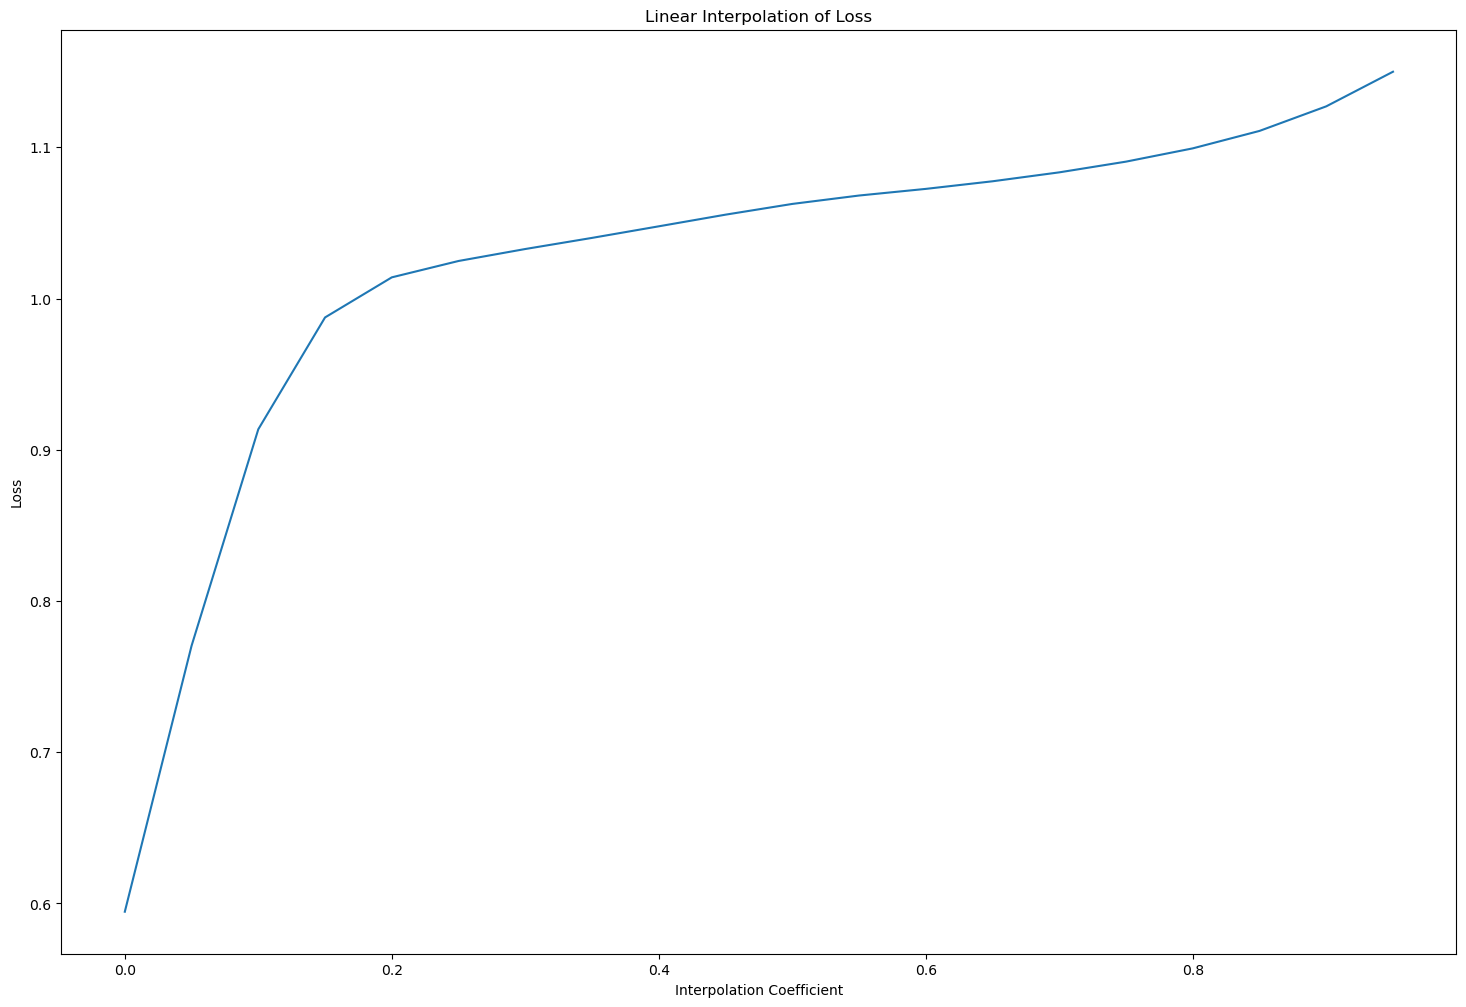

In [11]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

# Planar Approximations of Loss Around a Point

In [12]:
from loss_landscapes.model_interface.model_parameters import rand_u_like

# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.random_plane(distance=0.2, normalization='filter', random='normal')
# pll.interpolation(model_initial, model_initial)
pll.stats_initializer()

In [ ]:
# single batch computation
pll.warm_up(metric)
loss_data_fin = pll.compute(metric)

In [13]:
eval_warm_up(pll, dataloaders['train'], device, criterion)

In [14]:
loss_data_fin = eval_loss(pll, dataloaders['train'], device, criterion)

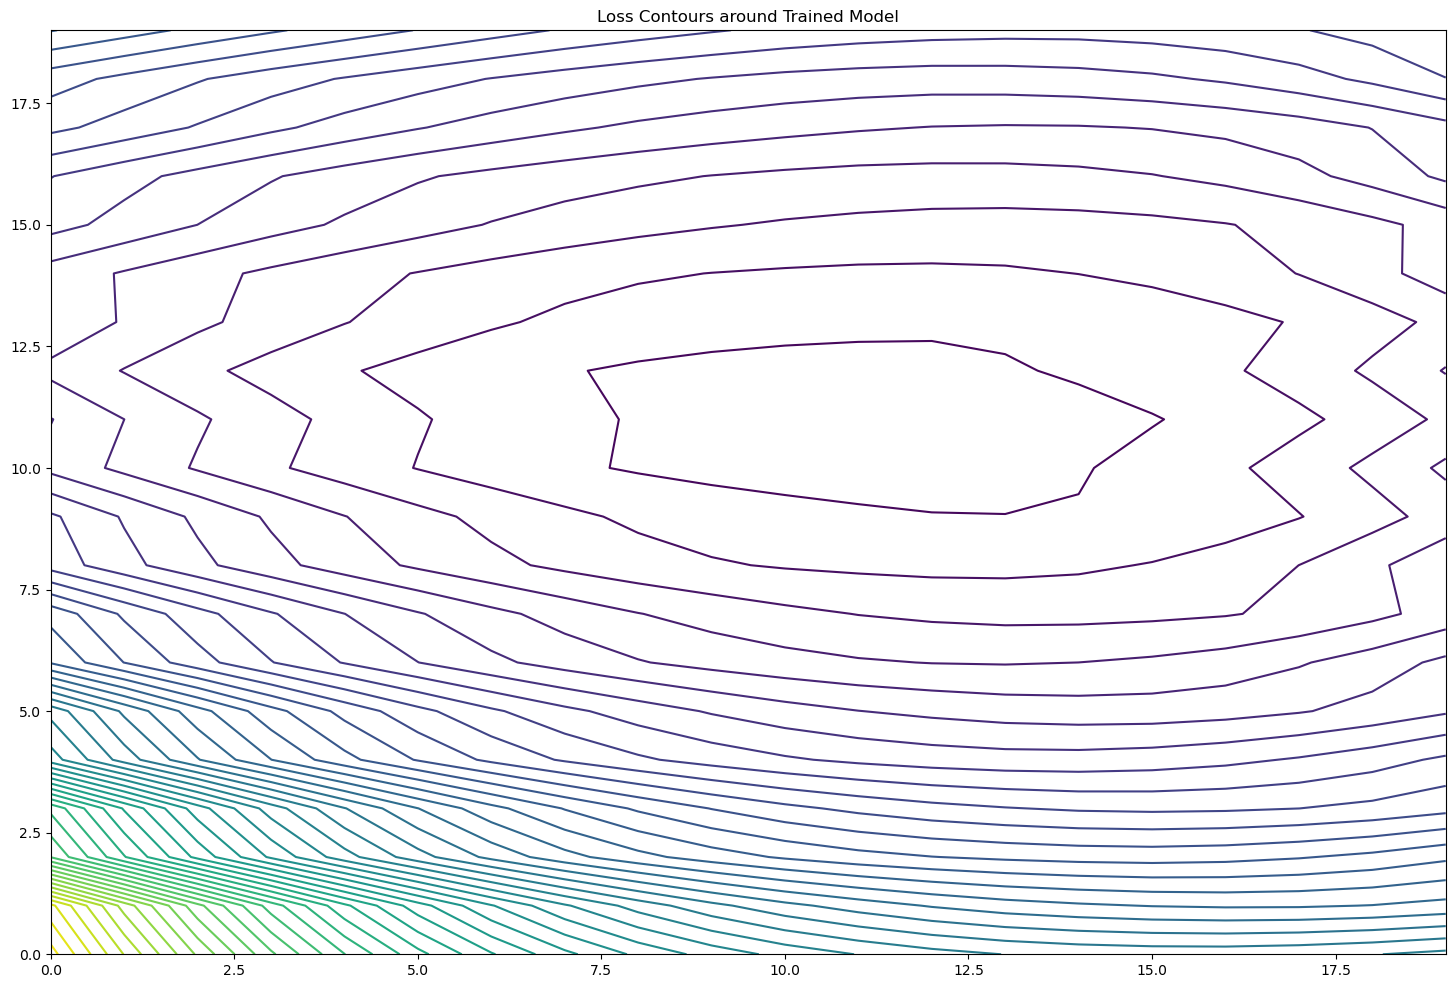

In [15]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

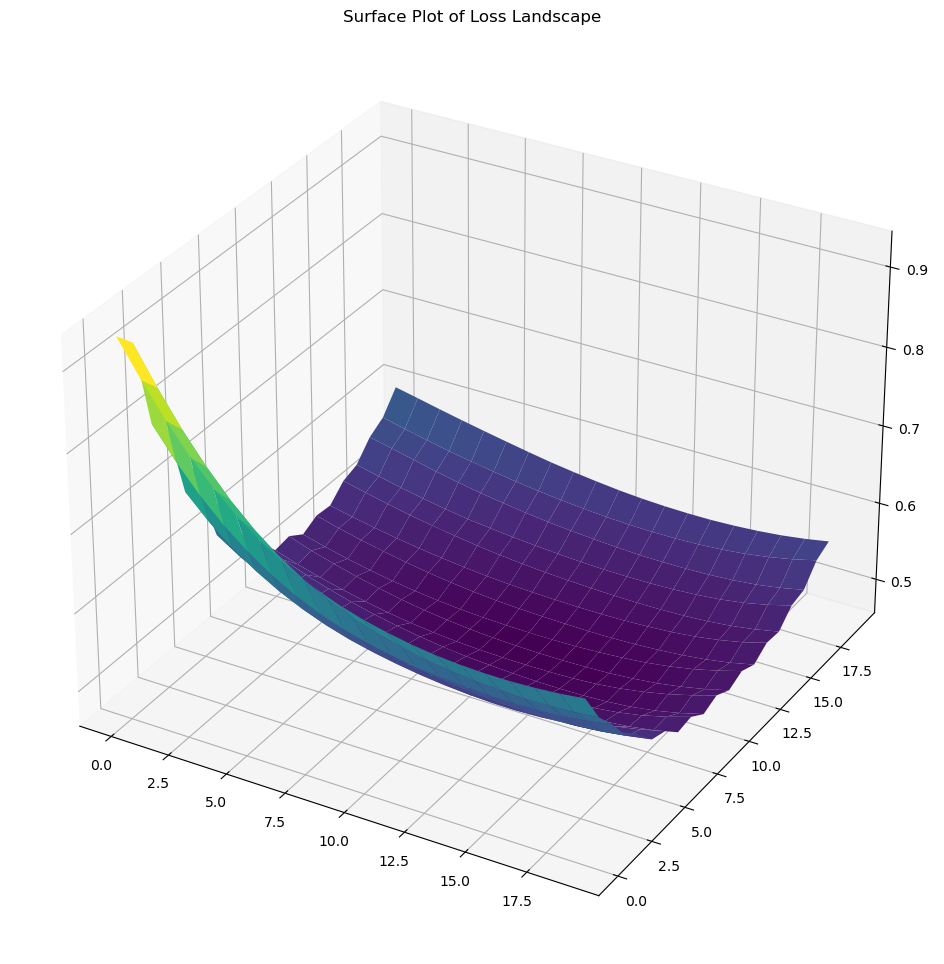

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()

In [ ]:
loss_data_fin.shape

In [ ]:
np.any(np.isnan(loss_data_fin))

In [ ]:
for name, param in pll.running_stats[-1][-1][0].items():
    print(torch.sum(torch.abs(pll.running_stats[-1][-1][0][name]-pll.running_stats[1][1][0][name])))